In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.plot as plot_scheme
import random

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/newdata2/'

my_ozone = Ozone(am_model_data_path=data_path)

nscale_map = my_ozone.data['Nscale']['map']
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * np.exp(nscale_map)

airmass_map = np.exp(my_ozone.data['airmass']['map'])
zenith_map = my_ozone._airmass_to_zenith(airmass_map)

# Randomize which AM generated datafile to use for testing
pwv_idx = random.randint(0, len(pwv_map) - 1)
zenith_idx = random.randint(0, len(zenith_map) - 1)
model_spectrum = my_ozone(pwv_map[pwv_idx], zenith_map[zenith_idx])

start_pwv=pwv_map[0]
end_pwv=pwv_map[1]
zenith_angle=1
points=100

airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(np.exp(airmass_map))
freq_channels = my_ozone.data['freq']['map']

start_zenith=zenith_map[1]
end_zenith=zenith_map[2]
pwv=5
points=100

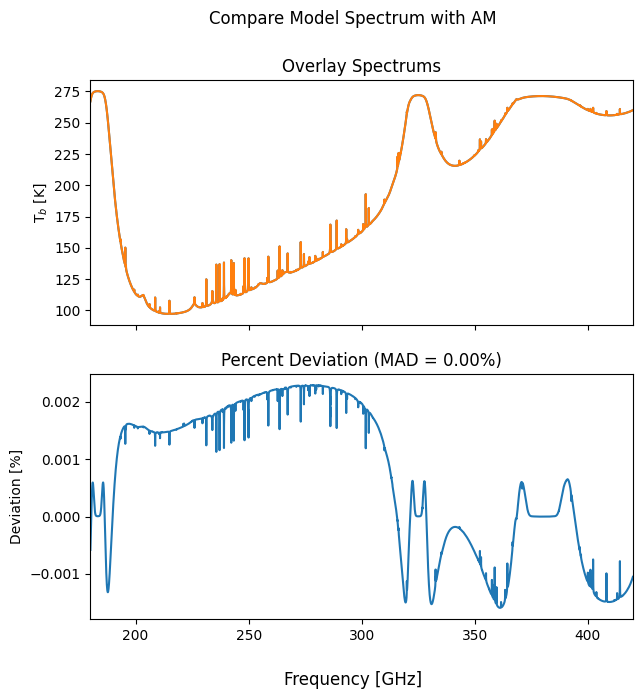

In [2]:
logairmass = 0.001
logNscale = 0.125
filename = f'MaunaKea_Tb_Spectrum_{logairmass:.3f}_{logNscale:+.3f}'
data = np.load(f'{my_ozone.am_model_data_path}{filename}.out')
Tb_data = data[:,2]

zenith_angle = my_ozone._airmass_to_zenith(np.exp(logairmass))
pwv = (np.exp(logNscale))*my_ozone.nominal_pwv
model_spectrum = my_ozone(pwv, zenith_angle)

difference_spectrum = ((model_spectrum - Tb_data) / Tb_data) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

ax1.plot(freq_channels, Tb_data)
ax1.plot(freq_channels, model_spectrum)
ax2.plot(freq_channels, difference_spectrum)

fig.supxlabel("Frequency [GHz]")
fig.suptitle("Compare Model Spectrum with AM")


ax1.set_title(f"Overlay Spectrums")
ax1.set_ylabel(r'T$_b$ [K]')

mad_deviation, max_deviation = np.percentile(difference_spectrum, [50, 99])
ax2.set_title(f"Percent Deviation (MAD = {mad_deviation:.2f}%)")
ax2.set_ylabel('Deviation [%]')
ax2.set_xlim(min(freq_channels), max(freq_channels));

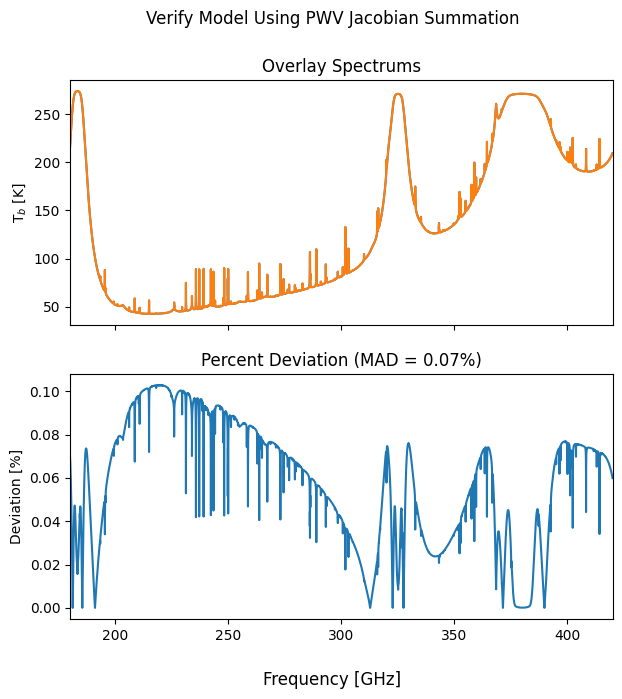

In [3]:
test_pwv_map = np.linspace(start_pwv, end_pwv, points)

base_spectrum = my_ozone(start_pwv, zenith_angle)
expected_spectrum = my_ozone(end_pwv, zenith_angle)

test_spectrum = base_spectrum
for pwv in test_pwv_map:
    pwv_jacobian = my_ozone(pwv, zenith_angle, return_pwv_jacobian=True, return_model_spectrum=False)
    little_jacobian = pwv_jacobian * ((end_pwv-start_pwv)/points)
    test_spectrum += little_jacobian

difference_spectrum = abs((test_spectrum - expected_spectrum) / expected_spectrum) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

ax1.plot(freq_channels, expected_spectrum)
ax1.plot(freq_channels, test_spectrum)
ax2.plot(freq_channels, difference_spectrum)

fig.supxlabel("Frequency [GHz]")
fig.suptitle("Verify Model Using PWV Jacobian Summation")


ax1.set_title(f"Overlay Spectrums")
ax1.set_ylabel(r'T$_b$ [K]')

mad_deviation, max_deviation = np.percentile(difference_spectrum, [50, 99])
ax2.set_title(f"Percent Deviation (MAD = {mad_deviation:.2f}%)")
ax2.set_ylabel('Deviation [%]')
ax2.set_xlim(min(freq_channels), max(freq_channels));

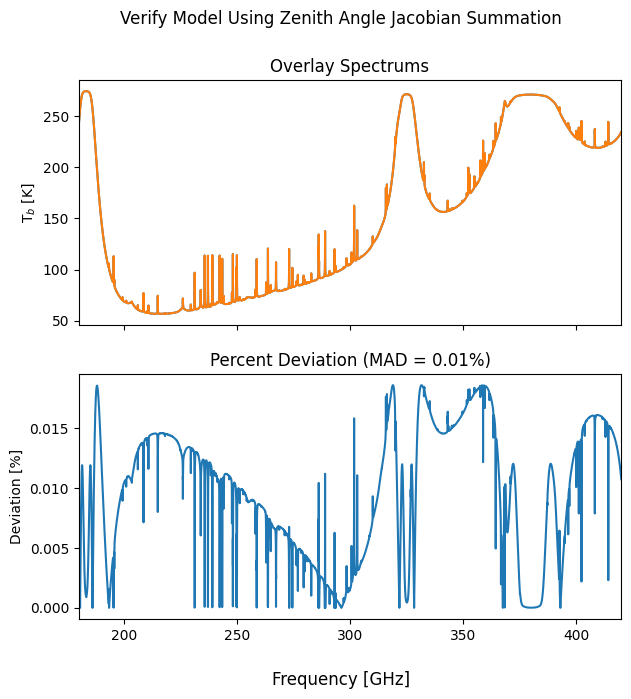

In [4]:
zenith_map = np.linspace(start_zenith, end_zenith, points)

base_spectrum = my_ozone(pwv, start_zenith)
expected_spectrum = my_ozone(pwv, end_zenith)

test_spectrum = base_spectrum
for zenith in zenith_map:
    zenith_jacobian = my_ozone(pwv, zenith, return_zenith_jacobian=True, return_model_spectrum=False)
    little_jacobian = zenith_jacobian * ((end_zenith-start_zenith)/points)
    test_spectrum += little_jacobian

difference_spectrum = abs((test_spectrum - expected_spectrum) / expected_spectrum) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

ax1.plot(freq_channels, expected_spectrum)
ax1.plot(freq_channels, test_spectrum)
ax2.plot(freq_channels, difference_spectrum)

fig.supxlabel("Frequency [GHz]")
fig.suptitle("Verify Model Using Zenith Angle Jacobian Summation")


ax1.set_title(f"Overlay Spectrums")
ax1.set_ylabel(r'T$_b$ [K]')

mad_deviation, max_deviation = np.percentile(difference_spectrum, [50, 99])
ax2.set_title(f"Percent Deviation (MAD = {mad_deviation:.2f}%)")
ax2.set_ylabel('Deviation [%]')
ax2.set_xlim(min(freq_channels), max(freq_channels));